# CSP model explainer

There are a few key pieces of the model:
- Variables (grammar.py)
- Constraints (constraints.py)
- Constraint integration & forgetting (utils/assignment_utils.py mostly)
- Turning games into CSPs, and motivation for model
- Agent model (agent.py)


In [1]:
from pathlib import Path
import sys, os


project_root = Path.cwd().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from grammar import Variable, Sum, Number
from constraints import EqualityConstraint, PartialConstraint
from agent import SubProblem, Agent, Result
from utils.assignment_utils import (
    print_assignments,
    integrate_new_constraint,
    integrate_constraints,
    integrate_constraints_and_forget,
    get_complexity,
    apply_combinatorial_capacity_noise,
    calculate_joint_entropy,
)

## (1) Variables (and Sum)

We use a small expression algebra to build models. For this intro, two building blocks matter most: `Variable` and `Sum`.

- **Variable**: A discrete variable with a finite domain (default `{0, 1}`). It can be assigned a value and composed into expressions.
  - `Variable(name, domain={0,1})`
  - `assign(value)` sets the variable’s value in-place (e.g., `v0.assign(1)` makes `v0` print as `1`).
  - `evaluate(assignment)` looks up the variable in a provided mapping and returns that value; if not present, it contributes `0` by default.
  - `apply(assignment)` substitutes any provided bindings and returns a simplified expression (possibly a `Number`).
  - `get_variables()` returns `{self}`.

- **Sum**: An n-ary addition over terms (variables, numbers, or other expressions). It flattens nested sums and performs light simplification.
  - `Sum(e1, e2, ...)`
  - `evaluate(assignment)` computes the numeric sum given a (partial or full) assignment.
  - `get_variables()` returns the union of variables across all terms.
  - `apply(assignment)` partially evaluates and simplifies the sum.

Below is an example showing partial vs full evaluation and the effect of in-place assignment versus passing an assignment mapping.

In [2]:
# Variables and Sums
v0 = Variable("v0")
v1 = Variable("v1")
v2 = Variable("v2")

S = Sum(v0, v1, v2)
print("Expression:", S)                    # (v0 + v1 + v2)
print("Variables:", {v.name for v in S.get_variables()})

# 1) Partial evaluation via an assignment mapping (no in-place changes)
partial = {v0: 1, v2: 0}
print("\nPartial assignment:", {k.name: v for k, v in partial.items()})
print("S.evaluate(partial):", S.evaluate(partial))
print("S after evaluate():", S)             # still symbolic, no in-place changes

# Apply the partial assignment (symbolic substitution + simplification)
S_applied = S.apply(partial)
print("S.apply(partial):", S_applied)        # e.g., (1 + v1)

# 2) Full evaluation via a complete assignment mapping
full = {v0: 1, v1: 1, v2: 0}
print("\nFull assignment:", {k.name: v for k, v in full.items()})
print("S.evaluate(full):", S.evaluate(full))
print("S.apply(full):", S.apply(full))       # collapses to a Number, e.g., 2

# 3) In-place assignment on a variable (does not affect a sum's evaluation)
v1.assign(1)
print("\nAfter v1.assign(1), expression prints as:", S)   # (v0 + 1 + v2)

# Note: evaluate() accepts a mapping and does not mutate expressions; assign() mutates the variable state.


Expression: (v0 + v1 + v2)
Variables: {'v2', 'v0', 'v1'}

Partial assignment: {'v0': 1, 'v2': 0}
S.evaluate(partial): 1
S after evaluate(): (v0 + v1 + v2)
S.apply(partial): (1 + v1)

Full assignment: {'v0': 1, 'v1': 1, 'v2': 0}
S.evaluate(full): 2
S.apply(full): 2

After v1.assign(1), expression prints as: (v0 + 1 + v2)


## (2) Constraints

The base `Constraint` class represents a relationship between a set of variables and a numeric `target`. Important points:

- `Constraint(variables: Set[Variable], target: int, **kwargs)` stores the variables, the target, and optional metadata such as `row`, `col`, `reset_first`, or `guess`. Each variable keeps a pointer back to the constraint.
- `get_variables`, `get_unassigned`, `get_assigned`, and `is_active` expose the current status of the variables tracked by the constraint.
- `get_effective_target(partial_assignment=None)` subtracts the contributions of any already-assigned variables (and any bindings supplied via `partial_assignment`) from the original target. The result is the remaining total the still-unassigned variables must realize, regardless of whether those variables are binary or have larger domains.
- `test_contradiction()` (implemented by subclasses) asks “can the remaining variables still reach the effective target?” If not, the constraint is currently impossible to satisfy.
- `evaluate(assignment)` (subclass-specific) expects a complete assignment mapping and returns `1` when the constraint is satisfied and `0` otherwise.
- `possible_solutions(partial_assignment=None, subset_vars=None)` lazily yields assignments that satisfy the constraint. You can optionally pass a partial assignment to condition on certain values and/or restrict enumeration to a subset of the unassigned variables. This is the **most important** method to understand.

Understanding these methods makes it easier to reason about concrete constraints, so next we focus on `EqualityConstraint`. (There are a bunch of other constraint types, like InequalityConstraints and UniquenessConstraints, but we'll just start with equalities, cause they're pretty simple...).


### EqualityConstraint

`EqualityConstraint(variables, target)` requires that the sum of a set of **binary** variables equals a specific integer `target`.

- **Arguments**: pass a set of `Variable` objects (each must have domain `{0,1}`) and a target sum. Optional metadata keywords are forwarded to the base class.
- **Effective target**: calling `get_effective_target()` subtracts every currently assigned variable’s value (plus any values provided via `partial_assignment`) from the required total. If the result falls outside the range `[0, #unassigned]`, we immediately know the constraint is impossible in its current state.
- **Contradiction**: `test_contradiction()` performs exactly that check. For equality, contradiction means “we need more 1s than we have spots left” or “we already overshot the target.”
- **Evaluate**: `evaluate(assignment)` plugs a complete assignment into the internal sum expression and returns `1` when the sum matches the effective target, `0` otherwise.
- **Possible solutions**: `possible_solutions(partial_assignment=None, subset_vars=None)` enumerates ways to assign the remaining variables so the sum lands on the effective target. With `subset_vars`, it will only generate solutions for that subset. 



#### Example

We create three binary variables and require exactly two of them to be 1. The code below shows:

1. The initial constraint description, effective target, and whether it's a contradiction.
2. Every satisfying assignment returned by `possible_solutions()` before any variables are fixed.
3. How assigning `v0 = 1` updates the effective target and reduces the solution set.
4. How to condition on an additional partial assignment without mutating the variables (passing `partial_assignment`).
5. An example using `subset_vars`.



In [3]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")

constraint = EqualityConstraint({v0, v1, v2}, target=2)
print("Constraint:", constraint)
print("Contradiction?:", constraint.test_contradiction())

# all possible variable assignments
print("\nVariable assignments:")
solutions = list(constraint.possible_solutions())
print_assignments(solutions)


Constraint: (v2 + v0 + v1 = 2)
Contradiction?: False

Variable assignments:

v0  v1  v2
----------
 1   1   0
 1   0   1
 0   1   1



In [4]:

# Assign v0 = 1 in-place to see how the remaining work changes
v0.assign(1)
print("\nAfter assigning v0 = 1...")
print("Constraint now prints as:", constraint)
print("Effective target:", constraint.get_effective_target())
print("Contradiction?:", constraint.test_contradiction())

# all possible (remaining) variable assignments with v0=1

print()
print("Variable assignments:")
solutions = list(constraint.possible_solutions())
print_assignments(solutions)

v0.unassign() #undoes mutation to v0



After assigning v0 = 1...
Constraint now prints as: (v2 + 1 + v1 = 2)
Effective target: 1
Contradiction?: False

Variable assignments:

v1  v2
------
 1   0
 0   1



In [5]:

# Condition on another variable without mutating it
temp_partial = {v2: 1}
print("\nCondition on v2 = 1 via partial_assignment (v2 remains unassigned globally):")
print("Effective target with partial:", constraint.get_effective_target(temp_partial))



Condition on v2 = 1 via partial_assignment (v2 remains unassigned globally):
Effective target with partial: 1


In [6]:

# Restrict enumeration to a subset of variables
subset_only = {v1}
print("\nRestrict possible_solutions to subset_vars = {v1}:")
for sol in constraint.possible_solutions(partial_assignment=temp_partial, subset_vars=subset_only):
    print("  subset assignment:", {var.name: val for var, val in sol.items()})


Restrict possible_solutions to subset_vars = {v1}:
  subset assignment: {'v2': 1, 'v1': 1}
  subset assignment: {'v2': 1, 'v1': 0}


#### Contradictions and `fix_contradiction()`

An equality constraint becomes contradictory when the already-assigned variables make the remaining target unattainable. Here’s an example with the constraint v0 + v1 + v2 = 1, then violate that requirement by overshooting the sum and recover using `fix_contradiction()`.


In [7]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")

constraint = EqualityConstraint({v0, v1, v2}, target=1) #v0 + v1 + v2 = 1
print(constraint)
print("Contradiction?:", constraint.test_contradiction())


(v2 + v0 + v1 = 1)
Contradiction?: False


Assigning both variables to 1 overshoots the target. With no unassigned variables left, the constraint is impossible to satisfy.


In [8]:
v0.assign(1)
v1.assign(1)
v2.assign(0)
print("Values now:", v0.value, v1.value, v2.value)
print("Effective target:", constraint.get_effective_target())
print("Contradiction?:", constraint.test_contradiction())


Values now: 1 1 0
Effective target: -1
Contradiction?: True


`fix_contradiction()` unassigns the smallest subset of variables that restores feasibility, returning the ones it had to release.


In [9]:
released = constraint.fix_contradiction()
print("Released vars:", {var.name for var in released})
print("Current values:", v0.value, v1.value, v2.value)
print("Contradiction?:", constraint.test_contradiction())


Released vars: {'v0', 'v1'}
Current values: None None 0
Contradiction?: False


The constraint now has room to satisfy the target again (only the definitely-unoffending variable remains assigned).

### Partial Constraints

A `PartialConstraint` keeps a reference to the original constraint but restricts attention to a subset of variables variables.


We’ll create a partial constraint that only tracks `v0` and `v1`, and then ignore `v2` with a PartialConstraint wrapper.


In [10]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")
base_constraint = EqualityConstraint({v0, v1, v2}, target=1) #v0 + v1 + v2 = 1
print(base_constraint)


(v2 + v0 + v1 = 1)


Wrap it with `PartialConstraint`, which simplifies it to only consider valid possibilities containing `{v0, v1}`. 


In [11]:
pc_partial = PartialConstraint(base_constraint, {v0, v1})
print(pc_partial)
print_assignments(list(pc_partial.possible_solutions()))


((v2 + v0 + v1 = 1), vars={v0,v1})

v0  v1
------
 0   0
 1   0
 0   1



`possible_solutions()` now enumerates assignments only for `v0` and `v1`, leaving `v2` untouched. 


If other variables that are part of the constraint but  not part of the partial constraint's context have already been assigned, the partial constraint will automatically reflect only the remaining valid possibilities. So e.g. if `v2 = 1`, then the partial constraint would return a dictionary with only `v0=0` and `v1=0` as a valid possibility.


In [12]:
v2.assign(1)
print("v2 assigned to 1 -> effective target for subset:", base_constraint.get_effective_target())
print("constraint now:", base_constraint)
print("Partial solutions now:")
print_assignments(list(pc_partial.possible_solutions()))
v2.unassign()  # clean up for future cells


v2 assigned to 1 -> effective target for subset: 0
constraint now: (1 + v0 + v1 = 1)
Partial solutions now:

v0  v1
------
 0   0



## (3) Constraint integration

So far we have treated constraints one at a time. In this section we'll look at how to handle constraint integration, i.e., when we want to combine the possible solutions implied by multiple constraints. 



In [13]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")
c_eq1 = EqualityConstraint({v0, v1, v2}, target=1)
assignments_full = integrate_new_constraint([], c_eq1)
print("All assignments for v0 + v1 + v2 = 1:")
print_assignments(assignments_full)

true_entropy = calculate_joint_entropy(assignments_full)
print(f"True joint entropy before culling (bits): {true_entropy:.2f}")
print(f"Complexity before culling (bits): {get_complexity(assignments_full):.2f}")

# Apply a tight capacity so we are forced to forget some assignments
capacity_bits = 5.0
assignments_noisy = apply_combinatorial_capacity_noise(assignments_full, capacity_bits)
print("Post-culling assignments:")
print_assignments(assignments_noisy)

current_entropy = calculate_joint_entropy(assignments_noisy)
print(f"Joint entropy after culling (bits): {current_entropy:.2f}")
print(f"Complexity after culling (bits): {get_complexity(assignments_noisy):.2f}")
print(f"Information loss (bits): {true_entropy - current_entropy:.2f}")

All assignments for v0 + v1 + v2 = 1:

v0  v1  v2
----------
 1   0   0
 0   1   0
 0   0   1

True joint entropy before culling (bits): 1.58
Complexity before culling (bits): 5.81
Post-culling assignments:

v0  v1  v2
----------
 0   0   1
 1   0   0

Joint entropy after culling (bits): 1.00
Complexity after culling (bits): 4.81
Information loss (bits): 0.58


In [14]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")
# Start from all assignments satisfying v0 + v1 + v2 = 1
c_eq1 = EqualityConstraint({v0, v1, v2}, target=1)
assignments_full = integrate_new_constraint([], c_eq1)
print("All assignments for v0 + v1 + v2 = 1:")
print_assignments(assignments_full)

true_entropy = calculate_joint_entropy(assignments_full)
print(f"True joint entropy before culling (bits): {true_entropy:.2f}")
print(f"Complexity before culling (bits): {get_complexity(assignments_full):.2f}")

# Apply a tight capacity so we are forced to forget some assignments
capacity_bits = 5.0
assignments_noisy = apply_combinatorial_capacity_noise(assignments_full, capacity_bits)
print("Post-culling assignments:")
print_assignments(assignments_noisy)

current_entropy = calculate_joint_entropy(assignments_noisy)
print(f"Joint entropy after culling (bits): {current_entropy:.2f}")
print(f"Complexity after culling (bits): {get_complexity(assignments_noisy):.2f}")
print(f"Information loss (bits): {true_entropy - current_entropy:.2f}")

All assignments for v0 + v1 + v2 = 1:

v0  v1  v2
----------
 1   0   0
 0   1   0
 0   0   1

True joint entropy before culling (bits): 1.58
Complexity before culling (bits): 5.81
Post-culling assignments:

v0  v1  v2
----------
 0   0   1
 1   0   0

Joint entropy after culling (bits): 1.00
Complexity after culling (bits): 4.81
Information loss (bits): 0.58


In [15]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")
c_eq1 = EqualityConstraint({v0, v1, v2}, target=1)
assignments_full = integrate_new_constraint([], c_eq1)
print("All assignments for v0 + v1 + v2 = 1:")
print_assignments(assignments_full)

true_entropy = calculate_joint_entropy(assignments_full)
print(f"True joint entropy before culling (bits): {true_entropy:.2f}")
print(f"Complexity before culling (bits): {get_complexity(assignments_full):.2f}")

# Apply a tight capacity so we are forced to forget some assignments
capacity_bits = 5.0
assignments_noisy = apply_combinatorial_capacity_noise(assignments_full, capacity_bits)
print("Post-culling assignments:")
print_assignments(assignments_noisy)

current_entropy = calculate_joint_entropy(assignments_noisy)
print(f"Joint entropy after culling (bits): {current_entropy:.2f}")
print(f"Complexity after culling (bits): {get_complexity(assignments_noisy):.2f}")
print(f"Information loss (bits): {true_entropy - current_entropy:.2f}")

All assignments for v0 + v1 + v2 = 1:

v0  v1  v2
----------
 1   0   0
 0   1   0
 0   0   1

True joint entropy before culling (bits): 1.58
Complexity before culling (bits): 5.81
Post-culling assignments:

v0  v1  v2
----------
 0   1   0
 0   0   1

Joint entropy after culling (bits): 1.00
Complexity after culling (bits): 4.81
Information loss (bits): 0.58


### Integration without forgetting

At the most basic level, **integrating a constraint** means: given a list of assignments that were already consistent with previous constraints, intersect them with a new constraint by expanding or discarding assignments.

This is handled by two functions:

- `integrate_new_constraint(assignments, constraint, subset_vars=None, max_size=None, return_none_if_too_large=True)`
  - If `assignments` is empty, it just enumerates `constraint.possible_solutions()` and returns that list (optionally trimmed to `subset_vars`).
  - If `assignments` is non-empty, it takes each assignment in turn, calls `constraint.possible_solutions(partial_assignment=assignment)`, and collects all consistent extensions.
  - If the number of resulting assignments would exceed `max_size`, it either returns `None` (signal “too big”) or truncates the list.
- `integrate_constraints(constraints, subset_vars=None)`
  - Folds a list of constraints with `integrate_new_constraint`, starting from an empty assignment list.
  - The result is the set of assignments that satisfy **all** given constraints exactly (no forgetting yet).


In [16]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")



c1 = EqualityConstraint({v0, v1}, target=1)   # v0 + v1 = 1
c2 = EqualityConstraint({v1, v2}, target=1)   # v1 + v2 = 1

print("c1's assignments alone:")
print_assignments(list( c1.possible_solutions()))
print("c2's assignments alone:")
print_assignments(list(c2.possible_solutions()))




c1's assignments alone:

v0  v1
------
 1   0
 0   1

c2's assignments alone:

v1  v2
------
 1   0
 0   1



In [17]:

assignments = []
assignments = integrate_new_constraint(assignments, c1)
assignments = integrate_new_constraint(assignments, c2)
print("After integrating c1 and c2 we get:")
print_assignments(assignments)


After integrating c1 and c2 we get:

v0  v1  v2
----------
 0   1   0
 1   0   1



Above, the assignments after `c2` are exactly the joint assignments to `(v0, v1, v2)` that satisfy both constraints. If we had many more constraints, `integrate_constraints([...])` would just repeat this pattern across the whole list.


### Memory complexity of a set of assignments

As we integrate more constraints, the list of assignments can grow exponentially. To model a bounded memory system, we need a way to **measure how big a set of assignments is**.

`get_complexity(assignments)` does this by:

1. Letting \(N\) be the total number of possible assignments over the current variables (product of each variable’s domain size).
2. Letting \(k\) be the number of assignments we are currently storing.
3. Returning $\log_2 \binom{N}{k}$, i.e. the information needed to specify which \(k\) assignments (out of all \(N\)) we are keeping.

This quantity is measured in bits and grows both with more variables and with more assignments kept.


In [18]:
# Compute complexity of the joint assignments from the previous example
complexity_bits = get_complexity(assignments)
print(f"Number of assignments: {len(assignments)}")
print(f"Complexity (bits): {complexity_bits :.2f}")



Number of assignments: 2
Complexity (bits): 4.81


If we doubled the number of variables or the number of stored assignments, this complexity term would rise, capturing the idea that a richer assignment pool is more expensive to maintain in memory.


### Forgetting: combinatorial capacity noise and information loss

To model forgetting directly, we use `apply_combinatorial_capacity_noise(assignments, capacity_bits)`. Given a pool of assignments, it:

1. Computes their current complexity in bits.
2. If this exceeds `capacity_bits`, randomly drops assignments until the complexity is below the capacity.

We can measure the effect of this forgetting step by comparing:
- `true_entropy` = joint entropy of the assignments *before* culling, and
- `current_entropy` = joint entropy of the assignments *after* culling.

The **information loss** is simply `true_entropy - current_entropy`: how many bits of structure about the solution space were discarded to satisfy the capacity constraint.

In [ ]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")

# Start from all assignments satisfying v0 + v1 + v2 = 1
c_eq1 = EqualityConstraint({v0, v1, v2}, target=1)
assignments_full = integrate_new_constraint([], c_eq1)
print("All assignments for v0 + v1 + v2 = 1:")
print_assignments(assignments_full)

true_entropy = calculate_joint_entropy(assignments_full)
print(f"Complexity before culling (bits): {get_complexity(assignments_full):.2f}")
print(f"Joint entropy before culling (bits): {true_entropy:.2f}")

capacity_bits = 5.0 # 5 bit memory capacity
assignments_noisy = apply_combinatorial_capacity_noise(assignments_full, capacity_bits)

print(f"Post-culling assignments (to keep memory < {capacity_bits} bits):")
print_assignments(assignments_noisy)

current_entropy = calculate_joint_entropy(assignments_noisy)
print(f"Complexity after culling (bits): {get_complexity(assignments_noisy):.2f}")
print(f"Joint entropy after culling (bits): {current_entropy:.2f}")
print(f"Information loss (bits): {true_entropy - current_entropy:.2f}")


All assignments for v0 + v1 + v2 = 1:

v0  v1  v2
----------
 1   0   0
 0   1   0
 0   0   1

Complexity before culling (bits): 5.81
Joint entropy before culling (bits): 1.58
Post-culling assignments (to keep memory < 5.0 bits):

v0  v1  v2
----------
 1   0   0
 0   0   1

Complexity after culling (bits): 4.81
Joint entropy after culling (bits): 1.00
Information loss (bits): 0.58


## (4) Motivating a memory-bounded model


Before we even get into the model details, it's useful to discuss two things: 1) how to encode a game like Minesweeper in terms of the constraints/variables we've defined; and 2) what would happen if you naively just evaluated the constraints to reach a solution. 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from csp_games.minesweeper import load_stimuli, board_to_constraints
from animations.minesweeper_animations import render_game_state
from animations.constraint_system_to_graph import build_csp_graph, draw_csp_graph



csp_games/puzzles/minesweeper_5x5_hard.json


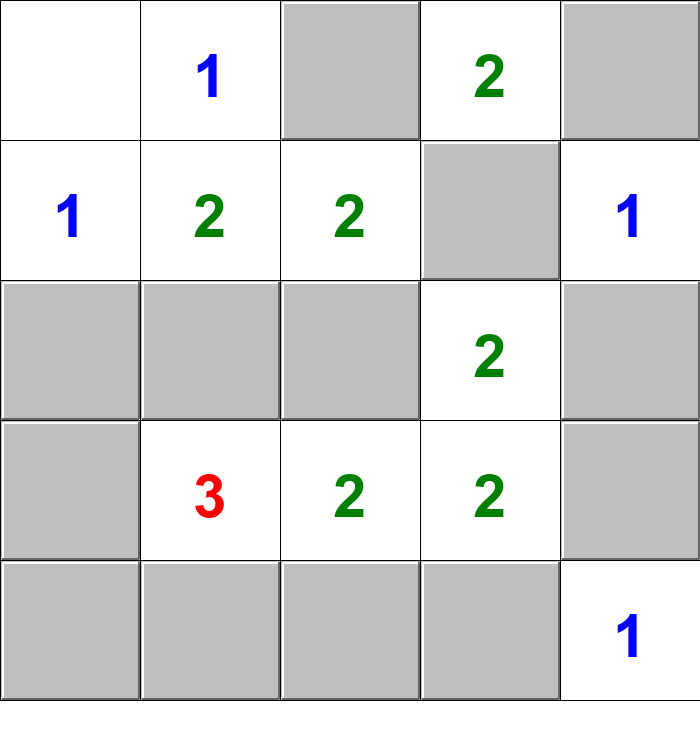

In [21]:
minesweeper_boards = load_stimuli("csp_games/puzzles/minesweeper_5x5_hard.json")
board = minesweeper_boards[-1]

render_game_state(board)

The panel above shows a single Minesweeper board. This is the raw input that we will turn into a collection of local equality constraints.


In [ ]:
constraints = board_to_constraints(board)

all_vars = set().union(*[c.get_variables() for c in constraints])
print(f"Number of variables: {len(all_vars)}")
print(f"Number of constraints: {len(constraints)}\n")

print("Constraints:")
for c in constraints[:8]:
    print(" ", c)
print("  ...")


Number of variables: 13
Number of constraints: 11

Constraints:
  (v_0_2 = 1)
  (v_0_4 + v_1_3 + v_0_2 = 2)
  (v_2_1 + v_2_0 = 1)
  (v_2_1 + v_2_0 + v_2_2 + v_0_2 = 2)
  (v_2_1 + v_1_3 + v_2_2 + v_0_2 = 2)
  (v_2_4 + v_1_3 + v_0_4 = 1)
  (v_2_4 + v_3_4 + v_1_3 + v_2_2 = 2)
  (v_3_0 + v_2_2 + v_4_0 + v_4_1 + v_2_1 + v_2_0 + v_4_2 = 3)
  ...


We can now re-draw these "minesweeper" constraints in a universal format that applies to any and all constraint satisfaction problem: a constraint graph. 

Below we can see the same board in CSP-graph format, where:
- Blue circular nodes correspond to latent binary variables (potential mine locations).
- Gray square nodes correspond to equality constraints induced by the numbered clues.
- An edge connects a variable to a constraint whenever that variable appears in the constraint.


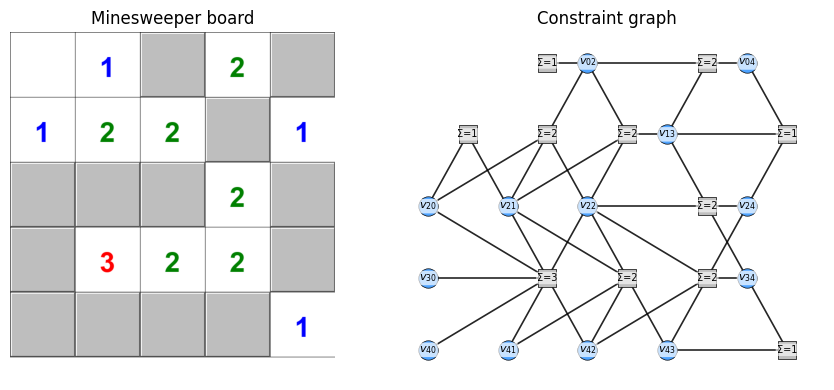

In [23]:

fig, (ax_board, ax_graph) = plt.subplots(1, 2, figsize=(9, 4))

img = render_game_state(board)
ax_board.imshow(img)
ax_board.set_title("Minesweeper board")
ax_board.axis("off")

vars_for_graph = set().union(*[c.get_variables() for c in constraints])
G = build_csp_graph(vars_for_graph, constraints)

draw_csp_graph(G, ax=ax_graph, use_board_coords=True, node_size=325, lw=0.8)
ax_graph.set_title("Constraint graph")

plt.tight_layout()

Okay, now, why don't we just look at each piece of information (i.e., a constraint) in turn and fully consider its implications? Well, in the graph below we can see what would happen if we tried to do this even on a tiny 5x5 board: the complexity of the solution space becomes unmanagably large, fast. 

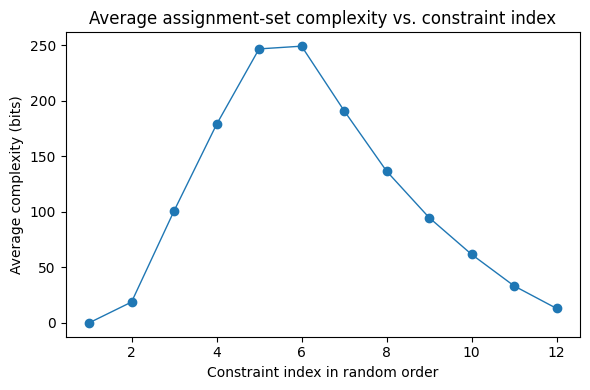

In [24]:

import random

n_runs = 100
n_constraints = len(constraints)
complexity_trajectories = np.zeros((n_runs, n_constraints+1))

for run in range(n_runs):
    shuffled = list(constraints)
    random.shuffle(shuffled)
    assignments = []
    for i, c in enumerate(shuffled):
        assignments = integrate_new_constraint(assignments, c)
        bits = get_complexity(assignments)
        complexity_trajectories[run, i+1] = bits

avg_complexity = complexity_trajectories.mean(axis=0)


x = np.arange(1, len(avg_complexity) + 1)

plt.figure(figsize=(6, 4))
plt.plot(x, avg_complexity, marker='o', linewidth=1)
plt.xlabel("Constraint index in random order")
plt.ylabel("Average complexity (bits)")
plt.title("Average assignment-set complexity vs. constraint index")
plt.grid(False)
plt.tight_layout()
plt.show()



Even for this small board, the plot above shows that integrating constraints in a random order typically drives the assignment set to **high complexity** after just a handful of steps, before eventually settling back down as the solution space narrows.

Random orderings differ in which constraints explode the space first, but on average the system quickly reaches a regime where storing all consistent assignments is extremely expensive. So people cannot handle even the joint implications of each constraint in a 5x5 minesweeper board - no way. 

Our model, which is described below, is aimed at explaining how a person with 10-15 bits of working memory might iteratively chip away at the problem by slowly expanding subproblems (local patches of the board), not allowing the memory demands to grow to intractable levels, and moving on to new problems when the current subproblem does not seem tractable given your memory limits.

## (5) Agent

The `Agent` builds and evaluate a **sequences of subproblems** out of a set of constraints, iteratively externalizing its (not always correct) deductions as it goes.

- It maintains global state:
  - `constraints` and `variables`: the full CSP it could ever reason about.
  - `current_subproblem` and `previous_subproblems`: where it is now vs. where it has been.
  - `solved_variables`: variables that have been globally fixed so far.
  - `information_gain_total` / `information_loss_total`: cumulative bits of uncertainty removed vs. bits discarded by forgetting.
  - `total_steps`: how many proposal steps it has taken overall.
- On each proposal step, the agent:
  1. **Samples a new constraint** and a subset of its unassigned variables.
  2. Uses `SubProblem.add(...)` to tentatively extend the current subproblem and recompute its assignments, IG, and IL under the current `memory_capacity`.
  3. Compares the new subproblem’s value `V(ILtol_current)` to the old one and **accepts or rejects** the proposal accordingly.
- The top-level loop:
  - **Resets** to a fresh `SubProblem` whenever the current one looks unpromising (e.g. expected discounted marks fall below `R_current`, or a contradiction / dead end is reached).
  - After each subproblem, calls `mark_solved_variables()` to commit any locally determined values into the global `solved_variables` set and update global IG/IL.
  - Stops when `max_steps` is reached, all variables are solved, or all variables of interest have been assigned.



### Subproblems

We'll first define what a **subproblem** is. A subproblem is basically just a subset of constraints and assignments being held in memory and iteratively modified by the agent. It consists of:

- a sequence of (partial) constraints currently in focus,
- the set of variables those constraints touch,
- a pool of candidate assignments over those variables, and
- bookkeeping about how much information has been gained and how much has been thrown away.

In code, this is represented by the `SubProblem` class in `agent.py`, which keeps:

- `constraints`: the active `PartialConstraint`s that define the subproblem.
- `unsimplified_constraints`: the original constraints before wrapping as partial ones.
- `variables`: the variables these constraints mention.
- `assignments`: the current candidate assignments over those variables.
- `information_gain`: how much uncertainty has been removed (via `get_IG_subproblem`).
- `information_loss`: how many bits were lost due to capacity limits when integrating constraints.
- `steps`: how many integration steps have been taken in this subproblem.
- `found_contradiction`: whether a hard contradiction was detected inside this subproblem.

The rest of this section explains the main methods on `SubProblem` that update and evaluate these fields. We’ll plug it into a full `Agent` loop later.


#### Key SubProblem methods

Here are the core operations on a `SubProblem` and what they mean conceptually:

- **`integrate_and_cull(constraint, memory_capacity)`**: takes the current assignment pool and integrates one more (partial) constraint using `integrate_constraints_and_forget`. This both tightens the assignments (enforcing the new constraint) and may drop some assignments if they no longer fit within `memory_capacity`. It then updates `information_gain` and accumulates any new `information_loss`.
- **`add(constraint, subset_vs=None, memory_capacity=np.inf)`**: convenience wrapper that chooses a subset of variables (`subset_vs` or all currently unassigned ones), wraps the constraint as a `PartialConstraint`, appends it to `constraints`, adds its variables to `variables`, and calls `integrate_and_cull`.
- **`increment_step()`**: records that we have taken one more integration step inside this subproblem (used for time-based metrics like `solved_by_time`).
- **`V(IL_max)`**: returns a scalar “value” of the subproblem: equal to its `information_gain` if `information_loss` is below `IL_max`, and `-∞` otherwise. This is what the agent later uses to decide whether a proposed subproblem is worth accepting.
- **`solved_by_time(t)`**: given a hypothetical time budget `t` (in steps), estimates how many variables are expected to be solved by then, based on how fast assignments have been culled so far.
- **`expected_discounted_marks(gamma, T=1)`**: turns `solved_by_time` into a discounted sum over time steps `1..T`, with discount factor `gamma`. This is the quantity compared against `R` in the agent loop.
- **`remove_solved_variables()`**: once some variables are fixed globally, this method removes them from the subproblem’s assignments and adjusts `information_loss` accordingly, so future steps only track genuinely unresolved variables.

Next we’ll create a tiny `SubProblem` by hand and walk through a couple of these operations without introducing the full agent loop yet.


In [25]:
v0, v1, v2 = Variable("v0"), Variable("v1"), Variable("v2")

# Start with an empty subproblem
sub = SubProblem()
print("Initial subproblem:")
print("  constraints:", sub.constraints)
print("  assignments:")
print_assignments(sub.assignments)
print("  IG =", sub.information_gain, "IL =", sub.information_loss)

# Add a simple constraint: exactly one of v0,v1 is 1
c1 = EqualityConstraint({v0, v1}, target=1)
sub.add(c1)
print("\nAfter add(c1: v0 + v1 = 1):")
print("  constraints:", sub.constraints)
print("  assignments:")
print_assignments(sub.assignments)
print("  IG =", sub.information_gain, "IL =", sub.information_loss)

# Add a second constraint, now involving v2 as well
c2 = EqualityConstraint({v1, v2}, target=1)
sub.add(c2)
print("\nAfter add(c2: v1 + v2 = 1):")
print("  constraints:", sub.constraints)
print("  assignments:")
print_assignments(sub.assignments)
print("  IG =", sub.information_gain, "IL =", sub.information_loss)

# Evaluate its value V under an IL budget
IL_budget = 2.0
print("\nSubproblem value V(IL_budget=2.0):", sub.V(IL_budget))

# (We will use solved_by_time and expected_discounted_marks later when we introduce the full agent loop.)


Initial subproblem:
  constraints: []
  assignments:
  IG = 0 IL = 0

After add(c1: v0 + v1 = 1):
  constraints: [((v0 + v1 = 1), vars={v0,v1})]
  assignments:

v0  v1
------
 1   0
 0   1

  IG = 1.0 IL = 0.0

After add(c2: v1 + v2 = 1):
  constraints: [((v0 + v1 = 1), vars={v0,v1}), ((v2 + v1 = 1), vars={v1,v2})]
  assignments:

v0  v1  v2
----------
 0   1   0
 1   0   1

  IG = 2.0 IL = 0.0

Subproblem value V(IL_budget=2.0): 2.0


### Agent loop

Now we let an `Agent` drive the creation of subproblems. The loop below mirrors a simplified version of `agent_loop` in `agent.py`:

- The agent repeatedly **resets** to a fresh `SubProblem`.
- Inside each subproblem it proposes constraints, either **accepting** or **rejecting** each proposal based on the subproblem value `V(ILtol)`.
- It decides to **stop growing** a subproblem either when the expected discounted marks (EDM) fall below `R` or when it hits a contradiction / runs out of constraints.
- After each subproblem, it **marks solved variables** and updates global `information_gain_total` and `information_loss_total` before moving on to the next subproblem.


Below, we run a model loop on the small minesweeper board we saw above.


In [ ]:
minesweeper_boards = load_stimuli("csp_games/puzzles/minesweeper_5x5_hard.json")
board = minesweeper_boards[-1]

constraints = board_to_constraints(board)

agent = Agent(
    constraints,
    memory_capacity=8,   #8 bits of memory capacity
    R_init=1,           # if i don't think i'll make 1 additional deduction next thinking step, stop
    ILtol_init=2.0,       # tolerate up to 2 bits of loss per subproblem
    max_steps=150
)

subproblem_index = 0

while not agent.check_if_finished():
    # Start a new subproblem
    agent.reset()
    subproblem_index += 1
    print("\n" + "=" * 70)
    print(f"NEW SUBPROBLEM {subproblem_index}")
    print(f"global IG_total={agent.information_gain_total:.2f}, IL_total={agent.information_loss_total:.2f}")
    print("globally solved vars:", {v.name: v.value for v in agent.solved_variables})
    print("=" * 70)

    # Inner loop: grow this subproblem
    while True:
        EDM = agent.current_subproblem.expected_discounted_marks(agent.gamma)
        print("\n--- sub-step", agent.current_subproblem.steps + 1, "---")
        print(f"total_steps={agent.total_steps}, sub_steps={agent.current_subproblem.steps}")
        print(f"R={agent.R_current:.2f}, ILtol={agent.ILtol_current:.2f}, EDM={EDM:.3f}")
        print(f"local IG={agent.current_subproblem.information_gain:.2f}, IL={agent.current_subproblem.information_loss:.2f}")
        print("constraints in subproblem:", agent.current_subproblem.constraints)
        print("assignments:")
        print_assignments(agent.current_subproblem.assignments)

        # Stopping rule based on expected discounted marks
        if EDM < agent.R_current and agent.current_subproblem.steps > 0:
            print("Stopping this subproblem because EDM < R.")
            break

        agent.increment_steps()
        result = agent.propose_step(simplify=True)
        prop = agent.last_proposal if agent.last_proposal else (None, None, None, False)
        print("proposal = constraint:", prop[0], "vars:", prop[1], "decision:", prop[2], "contradiction:", prop[3])

        if not agent.continue_with_subproblem(result):
            print("Ending this subproblem because:", result.name)
            break

    # After finishing the subproblem, mark any newly solved variables
    newly_solved = agent.mark_solved_variables()
    if newly_solved:
        print("Newly marked solved variables:", {v.name: val for v, val in newly_solved.items()})
    else:
        print("No new solved variables from this subproblem.")

    print(f"Updated global IG_total={agent.information_gain_total:.2f}, IL_total={agent.information_loss_total:.2f}")

print("\nAgent finished.")


csp_games/puzzles/minesweeper_5x5_hard.json

NEW SUBPROBLEM 1
global IG_total=0.00, IL_total=0.00
globally solved vars: {}

--- sub-step 1 ---
total_steps=0, sub_steps=0
R=1.00, ILtol=2.00, EDM=0.000
local IG=0.00, IL=0.00
constraints in subproblem: []
assignments:
proposal = constraint: (v_3_4 + v_4_3 = 1) vars: ['v_4_3'] decision: REJECT contradiction: False

--- sub-step 2 ---
total_steps=1, sub_steps=1
R=1.00, ILtol=2.00, EDM=0.000
local IG=0.00, IL=0.00
constraints in subproblem: []
assignments:
Stopping this subproblem because EDM < R.
No new solved variables from this subproblem.
Updated global IG_total=0.00, IL_total=0.00

NEW SUBPROBLEM 2
global IG_total=0.00, IL_total=0.00
globally solved vars: {}

--- sub-step 1 ---
total_steps=1, sub_steps=0
R=1.00, ILtol=2.00, EDM=0.000
local IG=0.00, IL=0.00
constraints in subproblem: []
assignments:
proposal = constraint: (v_3_4 + v_4_3 + v_2_2 + v_2_4 + v_4_2 = 2) vars: ['v_4_3', 'v_2_4', 'v_2_2', 'v_4_2'] decision: REJECT contradiction